In [8]:
%load_ext autoreload
%autoreload 2
%env TFHUB_CACHE_DIR=tfhub/

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
env: TFHUB_CACHE_DIR=tfhub/


In [9]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [10]:
import matplotlib
matplotlib.use("agg")
import matplotlib.pyplot as plt

In [11]:
import re

import numpy as np
import tensorflow as tf
from transformers import pipeline
import torch
from tqdm import tqdm

from src.bpe_summarizer import bpe_summarize, sentencizer
from validation import scicummnet_validation, similarity_score, mean_rouge_fscore

In [16]:
validation_set = scicummnet_validation("../validation/data/scisummnet_release1.1__20190413/")

In [35]:
random_sample = validation_set[np.random.randint(0, len(validation_set))]
assert random_sample is not None

In [36]:
sample_text, human_summary = random_sample
human_summary

'Overview of Genia Event Task in BioNLP Shared Task 2011\nThe Genia event task, a bio-molecular event extraction task, is arranged as one of the main tasks of BioNLP Shared Task 2011.\nAs its second time to be arranged for community-wide focused efforts, it aimed to measure the advance of the community since 2009, and to evaluate generalization of the technology to full text papers.\nAfter a 3-month system development period, 15 teams submitted their performance results on test cases.\nThe results show the community has made a significant advancement in terms of both performance improvement and generalization.\n'

In [44]:
bpe_summary = bpe_summarize(sample_text[:1024], percentile=50)
bpe_summary = re.sub(r"\n|\s{2,99}", "", bpe_summary)
bpe_summary

'Overview of Genia Event Task in BioNLP Shared Task 2011The Genia event task, a bio-molecular event extraction task, is arranged as one of the main tasks of BioNLP Shared Task 2011. The BioNLP Shared Task (BioNLP-ST, hereafter) is a series of efforts to promote a communitywide collaboration towards fine-grained information extraction (IE) in biomedical domain.'

In [45]:
mean_rouge_fscore(bpe_summary, human_summary)

0.46753246294063094

In [46]:
similarity_score(bpe_summary, human_summary)

-0.5385597

In [51]:
from transformers import BartTokenizer

# stripped down pipeline to only summarization task
# https://github.com/huggingface/transformers/blob/70bc3ead4f0b08e8cadd1805ada2a22f0c302399/src/transformers/pipelines.py#L1476

def bart_summarizer(text):
    bart_tokenizer: BartTokenizer = BartTokenizer.from_pretrained("facebook/bart-large")
    bart_tokens = bart_tokenizer.encode(text)
    return bart_tokenizer.decode(bart_tokens, skip_special_tokens=True, clean_up_tokenization_spaces=True,)

In [52]:
bart_summary = bart_summarizer(sample_text[:1024])
bart_summary

'\n  Overview of Genia Event Task in BioNLP Shared Task 2011\n  \n    The Genia event task, a bio-molecular event extraction task, is arranged as one of the main tasks of BioNLP Shared Task 2011.\n    As its second time to be arranged for community-wide focused efforts, it aimed to measure the advance of the community since 2009, and to evaluate generalization of the technology to full text papers.\n    After a 3-month system development period, 15 teams submitted their performance results on test cases.\n    The results show the community has made a significant advancement in terms of both performance improvement and generalization.\n  \n  \n    The BioNLP Shared Task (BioNLP-ST, hereafter) is a series of efforts to promote a communitywide collaboration towards fine-grained information extraction (IE) in biomedical domain.\n    The first event, BioNLP-ST 2009, introducing a biomolecular event (bio-event) extraction task to the community, attracted a wide attention, with 42 teams being

In [53]:
mean_rouge_fscore(bart_summary, human_summary)

0.7871485895872646

In [54]:
similarity_score(bart_summary, human_summary)

-0.7534034

In [55]:
sample_size = 100

In [56]:
bart_scores = []
bart_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bart_summary = bart_summarizer(sample_text[:1024])
    bart_summaries.append(bart_summary)
    bart_scores.append(similarity_score(bart_summary, human_summary))

100%|██████████| 100/100 [00:55<00:00,  1.81it/s]


In [57]:
np.mean(bart_scores)

-0.6517462

In [58]:
# TODO: abstract
bpe_scores = []
bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    bpe_summaries.append(bpe_summary)
    bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 105.86it/s]


In [59]:
np.mean(bpe_scores)

-0.5624839

(0.0, -1.0)

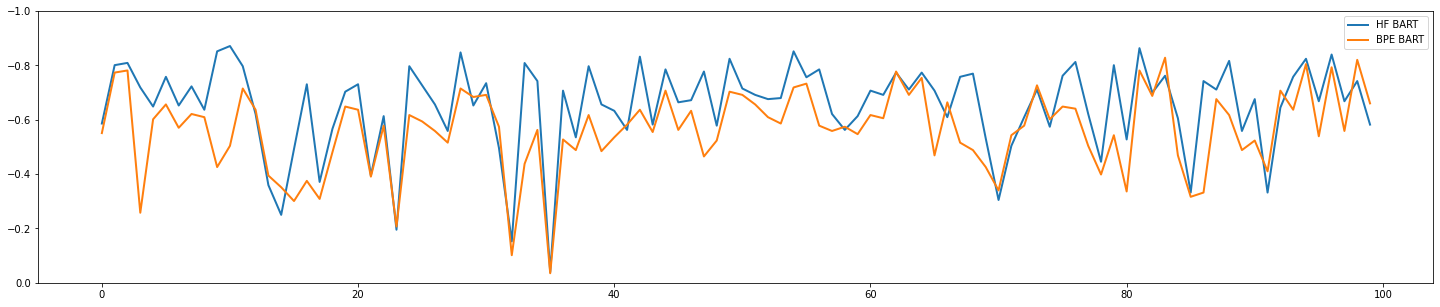

In [60]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(bpe_scores), linewidth=2, label='BPE BART')
ax.legend()

plt.ylim(0,-1)

In [61]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bpe_scores)
print(best_bpe)
best = bpe_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.828125


'Building Deep Dependency Structures Using A Wide-Coverage CCG Parser\nThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures.\nThe parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies.\nA set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank.\nThe parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies.\nWe provide examples showing how heads can fill dependency slots during a derivation, and how long-range dependencies can be recovered through unification of co-indexed head variables.\nWe define predicate argument structure f

In [62]:
bpe_summaries[best]

'Building Deep Dependency Structures Using A Wide-Coverage CCG ParserThis paper describes a wide-coverage statistical parser that uses Combinatory Categorial Grammar (CCG) to derive dependency structures. The parser differs from most existing wide-coverage treebank parsers in capturing the long-range dependencies inherent in constructions such as coordination, extraction, raising and control, as well as the standard local predicate-argument dependencies. A set of dependency structures used for training and testing the parser is obtained from a treebank of CCG normal-form derivations, which have been derived (semi-) automatically from the Penn Treebank. The parser correctly recovers over 80% of labelled dependencies, and around 90% of unlabelled dependencies.'

In [63]:
# closer to -1 indicate greater similarity
best_bpe = np.min(bart_scores)
print(best_bpe)
best = bart_scores.index(best_bpe)
_,human = validation_set[:sample_size][best]
human

-0.87109375


'Mildly Non-Projective Dependency Structures\nSyntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\nIn dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\nWhile projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\nIn this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\nThe results indicate that a combination of the well-nestedness constraint and a parametric con

In [64]:
bart_summaries[best]

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [65]:
t,human = validation_set[:sample_size][best]
result = bpe_summarize(t[:1024], percentile=70)
re.sub(r"\n|\s{2,99}", "", result)
t

'\n  Mildly Non-Projective Dependency Structures\n  \n    Syntactic parsing requires a fine balance between expressivity and complexity, so that naturally occurring structures can be accurately parsed without compromising efficiency.\n    In dependency-based parsing, several constraints have been proposed that restrict the class of permissible structures, such as projectivity, planarity, multi-planarity, well-nestedness, gap degree, and edge degree.\n    While projectivity is generally taken to be too restrictive for natural language syntax, it is not clear which of the other proposals strikes the best balance between expressivity and complexity.\n    In this paper, we review and compare the different constraints theoretically, and provide an experimental evaluation using data from two treebanks, investigating how large a proportion of the structures found in the treebanks are permitted under different constraints.\n    The results indicate that a combination of the well-nestedness con

In [66]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bpe_summarize(blob)
result

'The most meaningful part of this sentence is here.'

In [67]:
blob = "The most meaningful part of this sentence is here. I frost apples. Kung fu."
result = bart_summarizer(blob)
result

' The most meaningful part of this sentence is here. I frost apples. Kung fu.'

In [68]:
from transformers import GPT2Tokenizer
gpt2_tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
gpt2_bpe_scores = []
gpt2_bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70, tokenizer=gpt2_tokenizer)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    gpt2_bpe_summaries.append(bpe_summary)
    gpt2_bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 101.18it/s]


In [69]:
print("GPT2 Vocab Best:", np.min(gpt2_bpe_scores))
print("GPT2 Vocab Mean:", np.mean(gpt2_bpe_scores))

GPT2 Vocab Best: -0.82421875
GPT2 Vocab Mean: -0.5641245


(0.0, -1.0)

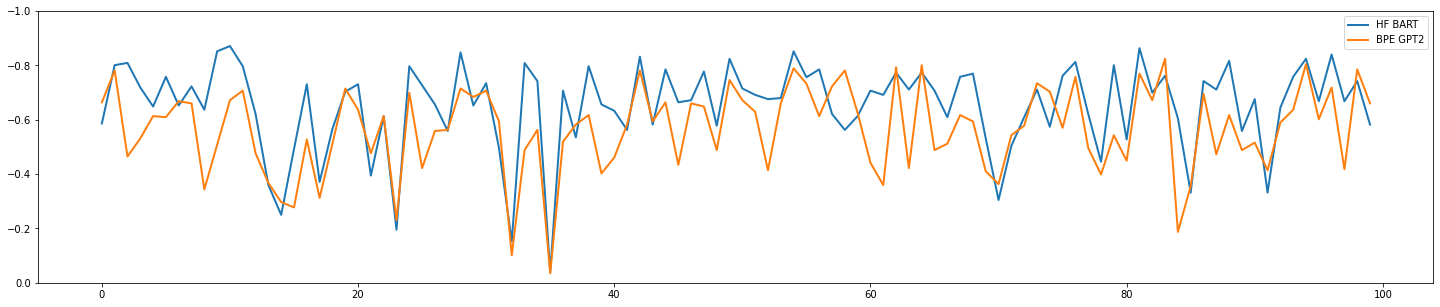

In [70]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(gpt2_bpe_scores), linewidth=2, label='BPE GPT2')
ax.legend()

plt.ylim(0,-1)

In [71]:
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
distilbert_bpe_scores = []
distilbert_bpe_summaries = []
for sample_text, human_summary in tqdm(validation_set[:sample_size]):
    bpe_summary = bpe_summarize(sample_text[:1024], percentile=70, tokenizer=distilbert_tokenizer)
    bpe_summary = re.sub(r"\s{2,99}", "", bpe_summary)
    distilbert_bpe_summaries.append(bpe_summary)
    distilbert_bpe_scores.append(similarity_score(bpe_summary, human_summary))

100%|██████████| 100/100 [00:00<00:00, 102.32it/s]


In [72]:
print("DistilBert Vocab Best:", np.min(distilbert_bpe_scores))
print("DistilBert Vocab Mean:", np.mean(distilbert_bpe_scores))

DistilBert Vocab Best: -0.8046875
DistilBert Vocab Mean: -0.5607616


(0.0, -1.0)

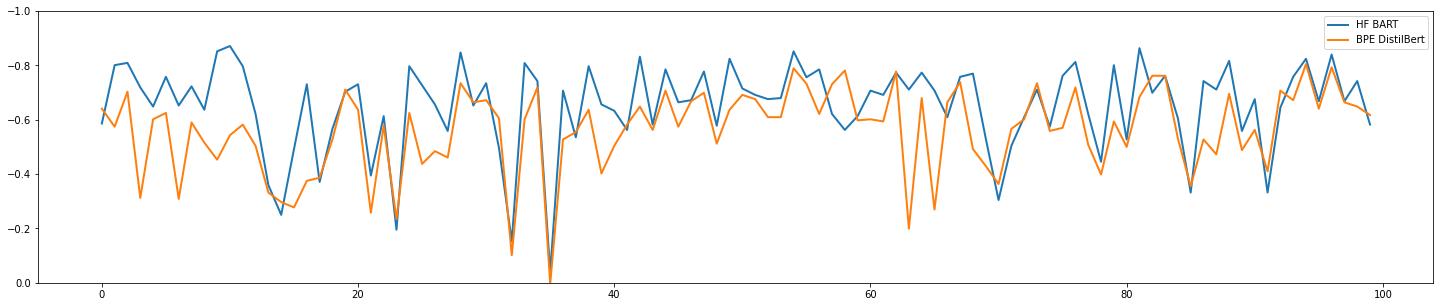

In [73]:
%matplotlib inline
fig = plt.figure(figsize=(25,5))
ax = fig.gca()
ax.plot(np.array(bart_scores), linewidth=2, label='HF BART')
ax.plot(np.array(distilbert_bpe_scores), linewidth=2, label='BPE DistilBert')
ax.legend()

plt.ylim(0,-1)